Will investigate the following 2 reviewer comments here:
(1) Is it possible to optimize the geometry? Or transition states and reaction paths? Perhaps this is the next step, but it would be essential to map out how strong coupling affects chemistry. For the Mg-Br system, is there an effect of the strong coupling on the ground state equilibrium?

(2) Somewhat related to my previous comments on the field strength: The diffference between the simple Jaynes-Cummings-like model (eq. 22) and the CQED-CIS method is very interesting to see, but how strong does the field need to be in order to see these differences. Might it be that for moderate fields, which may be more in line with experiment, in particular for optical cavities, the differences would dissappear?
Still needs to be addressed.



In [1]:
from __future__ import print_function

"""
A script to run the cqed_rhf and cqed_cis method on MgH+ potential energy surface in a cc-pVDZ basis set,
reproducing data from Figure 3 by McTague and Foley.
"""

__authors__   = ["Jon McTague", "Jonathan Foley"]
__credits__   = ["Jon McTague", "Jonathan Foley"]

__copyright_amp__ = "(c) 2014-2018, The Psi4NumPy Developers"
__license__   = "BSD-3-Clause"
__date__      = "2021-01-15"

# ==> Import Psi4, NumPy, & SciPy <==
import psi4
import numpy as np
from helper_cqed_rhf import *
from helper_cis import *
from helper_cs_cqed_cis import *
from psi4.driver.procrouting.response.scf_response import tdscf_excitations
from matplotlib import pyplot as plt
# Set Psi4 & NumPy Memory Options
psi4.set_memory('2 GB')
psi4.core.set_output_file('output.dat', False)

numpy_memory = 2


Methods to fit Pauli-Fierz and Jaynes-Cummings models to CIS data for the ground- and excited-state
of a quantum system (including transition dipole moments in both cases, and the total dipole
moments in the Pauli-Fierz case) given a photon frequency and coupling strength.

In [9]:
# functions for Pauli-Fierz and Jaynes-Cummings model Hamiltonians

def pauli_fierz(e1, e2, omega, lam, mu_g, mu_e, mu_eg):
    H = np.zeros((3,3),dtype=complex)
    l_d_mu_g = np.dot(lam, mu_g)
    l_d_mu_e = np.dot(lam, mu_e)
    l_d_tdm  = np.dot(lam, mu_eg)
    
    H[0,0] = e1 + 0.5 * l_d_mu_g ** 2
    H[1,1] = e1 + omega + 0.5 * l_d_mu_g ** 2
    H[2,2] = e2 + 0.5 * l_d_mu_e ** 2
    H[1,2] = np.sqrt(omega/2) * l_d_tdm
    H[2,1] = np.sqrt(omega/2) * l_d_tdm

    
    # diagonalize
    vals, vecs = la.eig(H)
    idx = vals.argsort()[::1]
    vals = vals[idx]
    vecs = vecs[:,idx]
    return vals[0], vals[1], vals[2], vecs

def jaynes_cummings(e1, e2, omega, lam, mu_eg):
    H = np.zeros((3,3),dtype=complex)
    l_d_tdm = np.dot(lam, mu_eg)
    H[0,0] = e1 + omega
    H[1,1] = e2
    H[0,1] = np.sqrt(omega/2) * l_d_tdm
    H[1,0] = np.sqrt(omega/2) * l_d_tdm
    
    # diagonalize
    vals, vecs = la.eig(H)
    idx = vals.argsort()[::1]
    vals = vals[idx]
    return vals[0], vals[1]


# MgH+ ground-state surfaces with strong coupling (Fig 5)

This cell will compute the ground-state potential energy surface with RHF, QED-RHF, and QED-CIS to determine if strong-coupling alters the equilibrium geometry of the ground-state

In [15]:
# specific MgH+ geometry
mol_str = """
Mg
H 1 1.3
symmetry c1
1 1
"""

# template for z-matrix with variable bondlength
mol_tmpl = """
Mg
H 1 **R**
symmetry c1
1 1
"""

# options dict
options_dict = {'basis': 'cc-pVDZ',
               'save_jk': True, 
               'scf_type': 'pk'}

# set psi4 options and geometry
psi4.set_options(options_dict)
mol = psi4.geometry(mol_str)

# set psi4 options
psi4.set_options(options_dict)

# array of bondlengths for MgH+
r_array = np.array([1.60, 1.61, 1.62, 1.63, 1.64, 1.65, 1.66, 1.67, 1.68, 1.69, 1.70]) #, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3])



# array to hold the cs-cqed-cis energies
# array for cqed cis
cqed_cis_energy_array = np.zeros(len(r_array),dtype=complex)
cqed_rhf_energy_array = np.zeros(len(r_array))
rhf_energy_array = np.zeros(len(r_array))
# electric field strength 
lam_z = 0.0125

# photon energy
om_r = 4.75 / 27.211

# approximate maximum value of transition dipole moment in a.u.
max_tdm = 2.25

# approximate max value of g
g_max = np.sqrt(om_r/2) * lam_z * max_tdm

print(" value of gamma to cross over from weak to strong coupling:", 4 * g_max)
om = om_r - 0 * (g_max/2) * 1j

# lambda vector
lam = np.array([0,0,lam_z])

# loop over the different bond-lengths, create different instances
# of MgH+ molecule and compute and store various quantities
ctr = 0
for r in r_array:
    molstr = mol_tmpl.replace("**R**", str(r))
    mol = psi4.geometry(molstr)
    e, wfn = psi4.energy("scf/cc-pVDZ", return_wfn=True, molecule=mol)
    cqed_dict = cs_cqed_cis(lam, om, molstr, options_dict)
    
    # get cqed-rhf energy
    cqed_scf_e = cqed_dict['CQED-RHF ENERGY']
    # get cqed-cis excitation energies
    cqed_cis_e = cqed_dict['CQED-CIS ENERGY']
    # store to arrays
    cqed_cis_energy_array[ctr] = cqed_scf_e+cqed_cis_e[0]
    rhf_energy_array[ctr] = e
    cqed_rhf_energy_array[ctr] = cqed_scf_e
    ctr+=1
    

 

 value of gamma to cross over from weak to strong coupling: 0.033236254686047906
C
23
Cocc
23

Start SCF iterations:

Canonical RHF One-electron energy = -283.9486473578405139
CQED-RHF One-electron energy      = -283.9489458552046131
Nuclear repulsion energy          = 3.9688290800249999
Dipole energy                     = 0.0007254284632068
SCF Iteration   1: Energy = -199.8973968244046091   dE = -1.99897E+02   dRMS = 1.68280E-05
SCF Iteration   2: Energy = -199.8973972592654604   dE = -4.34861E-07   dRMS = 6.18042E-06
SCF Iteration   3: Energy = -199.8973973125966666   dE = -5.33312E-08   dRMS = 2.37777E-06
Total time for SCF iterations: 0.007 seconds 

QED-RHF   energy: -199.89739731 hartree
Psi4  SCF energy: -199.89777063 hartree
C
23
Cocc
23

Start SCF iterations:

Canonical RHF One-electron energy = -283.8986298879413539
CQED-RHF One-electron energy      = -283.8989283889746957
Nuclear repulsion energy          = 3.9441779677267079
Dipole energy                     = 0.0007296933

No handles with labels found to put in legend.


r_eq from cqed_cis 1.6565656565656566
r_eq from cqed_rhf 1.6565656565656566
r_eq from rhf 1.6575757575757577
force constant from cqed_cis 0.40990764104107075
force constant from cqed_rhf 0.41015917496382964
force constant from rhf 0.4082864540085504


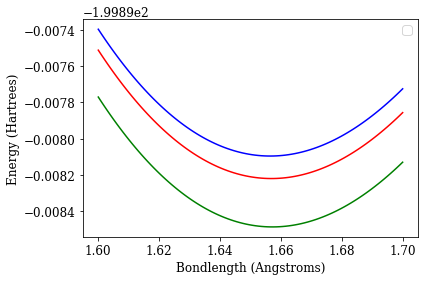

In [16]:
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import rcParams
from scipy.interpolate import InterpolatedUnivariateSpline

# fit each surface to a spline
cqed_cis_spline = InterpolatedUnivariateSpline(r_array, np.real(cqed_cis_energy_array), k=3)
cqed_rhf_spline = InterpolatedUnivariateSpline(r_array, np.real(cqed_rhf_energy_array), k=3)
rhf_spline = InterpolatedUnivariateSpline(r_array, np.real(rhf_energy_array), k=3)

# evaluate each spline on a finer grid
r_fine = np.linspace(1.6, 1.7, 100)
cqed_cis_e_fine = cqed_cis_spline(r_fine)
cqed_rhf_e_fine = cqed_rhf_spline(r_fine)
rhf_e_fine = rhf_spline(r_fine)

# get curvatures of each surface
cqed_cis_f = cqed_cis_spline.derivative()
cqed_cis_c = cqed_cis_f.derivative()

cqed_rhf_f = cqed_rhf_spline.derivative()
cqed_rhf_c = cqed_rhf_f.derivative()

rhf_f = rhf_spline.derivative()
rhf_c = rhf_f.derivative()

# get locations of equilibrium geometry
r_eq_cqed_cis = r_fine[np.argmin(cqed_cis_e_fine)]
r_eq_cqed_rhf = r_fine[np.argmin(cqed_rhf_e_fine)]
r_eq_rhf = r_fine[np.argmin(rhf_e_fine)]

# print location of equilibrium bondlength
print("r_eq from cqed_cis",r_eq_cqed_cis)
print("r_eq from cqed_rhf",r_eq_cqed_rhf)
print("r_eq from rhf",r_eq_rhf)

# print curvature evaluated at equilibrium geometries
k_cqed_cis = cqed_cis_c(r_eq_cqed_cis)
k_cqed_rhf = cqed_rhf_c(r_eq_cqed_rhf)
k_rhf = rhf_c(r_eq_rhf)

# print the force constant of each surface in atomic units
print("force constant from cqed_cis",k_cqed_cis)
print("force constant from cqed_rhf",k_cqed_rhf)
print("force constant from rhf",k_rhf)


# plot surfaces on fine grid
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 12
plt.plot(r_fine, cqed_cis_e_fine, 'red')
plt.plot(r_fine, cqed_rhf_e_fine, 'blue')
plt.plot(r_fine, rhf_e_fine, 'green')
plt.xlabel("Bondlength (Angstroms)")
plt.ylabel("Energy (Hartrees)")
plt.legend()
plt.show()

In [6]:
# print values to file for gnuplotting
for i in range(0, len(r_array)):
    print(r_array[i], rhf_energy_array[i], np.real(cqed_rhf_energy_array[i]), np.real(cqed_cis_energy_array[i]))




1.6 -199.89777062599617 -199.89739731259667 -199.89751243750015
1.61 -199.89800435908424 -199.89762816553565 -199.89774478388608
1.62 -199.89819007994012 -199.8978109610939 -199.89792909759038
1.63 -199.89832939409234 -199.89794730476697 -199.89806698420722
1.64 -199.89842385379214 -199.89803874876924 -199.89815999604926
1.65 -199.89847496024473 -199.89808679426807 -199.89820963438132
1.66 -199.89848416572607 -199.898092893498 -199.89821735153475
1.67 -199.89845287558924 -199.89805845176772 -199.8981845529141
1.68 -199.89838245016546 -199.89798482936376 -199.89811259890064
1.69 -199.89827420657076 -199.89787334335432 -199.8980028066562
1.7 -199.89812942041445 -199.89772526930028 -199.89785645183395


# Equilibrium bondlength of excited and polaritonic surfaces
This will explore the equilibrium bondlength of the first few excited states from CIS and the lower- and upper-polariton surfaces from QED-CIS.  

In [7]:
# template for z-matrix
mol_tmpl = """
Mg
H 1 **R**
symmetry c1
1 1
"""

# set psi4 options
psi4.set_options(options_dict)
# array of bondlengths for MgH+
r_array = np.array([1.85,1.86,1.87,1.88,1.89,1.90, 1.91, 1.92, 1.93, 1.94, 1.95, 1.96, 1.97, 1.98]) #, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3])

# arrays to hold psi4 cis quantities to fit the model PF Hamiltonian with
# array for transition dipole moments
tdm_array = np.zeros((3, len(r_array)))

# array for total diplole of ground and excited state 
dipole_array = np.zeros((3,2,len(r_array)))

# array for ordinary cis
cis_energy_array = np.zeros((5,len(r_array)))

# array to hold the cs-cqed-cis energies
# array for cqed cis
cqed_cis_energy_array = np.zeros((5,len(r_array)),dtype=complex)

# array for model Pauli-Fierz energies
pf = np.zeros((3,len(r_array)),dtype=complex)

# array for Jaynes-Cummings energies
jc = np.zeros((2,len(r_array)),dtype=complex)

# electric field strength 
lam_z = 0.0125

# photon energy
om_r = 4.75 / 27.211

# approximate maximum value of transition dipole moment in a.u.
max_tdm = 2.25

# approximate max value of g
g_max = np.sqrt(om_r/2) * lam_z * max_tdm

print(" value of gamma to cross over from weak to strong coupling:", 4 * g_max)
om = om_r 

# lambda vector
lam = np.array([0,0,lam_z])

# loop over the different bond-lengths, create different instances
# of MgH+ molecule and compute and store various quantities
ctr = 0
for r in r_array:
    molstr = mol_tmpl.replace("**R**", str(r))
    mol = psi4.geometry(molstr)
    e, wfn = psi4.energy("scf/cc-pVDZ", return_wfn=True, molecule=mol)
    
    # confirm our cis agrees with psi4
    res = tdscf_excitations(wfn, states=3, triplets = "NONE", tda=True)
    
    # parse res for excitation energies
    psi4_excitation_e = [r["EXCITATION ENERGY"] for r in res]
    
    cis_energy_array[0,ctr] = e
    cis_energy_array[0,ctr] = e+psi4_excitation_e[0]
    
    
    cqed_dict = cs_cqed_cis(lam, om, molstr, options_dict)
    
    # get cqed-rhf energy
    cqed_scf_e = cqed_dict['CQED-RHF ENERGY']
    # get cqed-cis excitation energies
    cqed_cis_e = cqed_dict['CQED-CIS ENERGY']
    # store to arrays
    cqed_cis_energy_array[0:5,ctr] = cqed_scf_e+cqed_cis_e[0:5]
    ctr+=1
    

 

 value of gamma to cross over from weak to strong coupling: 0.033236254686047906
C
23
Cocc
23

Start SCF iterations:

Canonical RHF One-electron energy = -282.8388415656265806
CQED-RHF One-electron energy      = -282.8391163177977887
Nuclear repulsion energy          = 3.4325008259675673
Dipole energy                     = 0.0008274548201318
SCF Iteration   1: Energy = -199.8918700532063610   dE = -1.99892E+02   dRMS = 2.00072E-05
SCF Iteration   2: Energy = -199.8918707231253222   dE = -6.69919E-07   dRMS = 7.47140E-06
SCF Iteration   3: Energy = -199.8918708055141167   dE = -8.23888E-08   dRMS = 2.89621E-06
Total time for SCF iterations: 0.006 seconds 

QED-RHF   energy: -199.89187081 hartree
Psi4  SCF energy: -199.89232977 hartree
C
23
Cocc
23

Start SCF iterations:

Canonical RHF One-electron energy = -282.7998202794781832
CQED-RHF One-electron energy      = -282.8000930112049218
Nuclear repulsion energy          = 3.4140465204516128
Dipole energy                     = 0.0008313042

C
23
Cocc
23

Start SCF iterations:

Canonical RHF One-electron energy = -282.3587705480425711
CQED-RHF One-electron energy      = -282.3590121233777950
Nuclear repulsion energy          = 3.2071346101212135
Dipole energy                     = 0.0008756974275437
SCF Iteration   1: Energy = -199.8828616902606257   dE = -1.99883E+02   dRMS = 2.18968E-05
SCF Iteration   2: Energy = -199.8828625231348042   dE = -8.32874E-07   dRMS = 8.22328E-06
SCF Iteration   3: Energy = -199.8828626247297109   dE = -1.01595E-07   dRMS = 3.17546E-06
SCF Iteration   4: Energy = -199.8828626395025196   dE = -1.47728E-08   dRMS = 1.22120E-06
Total time for SCF iterations: 0.009 seconds 

QED-RHF   energy: -199.88286264 hartree
Psi4  SCF energy: -199.88337751 hartree


Plot the polaritonic surfaces from the different levels of theory against the CIS electronic surfaces.

cqed_cis 1.8893939393939394
cis 1.9235353535353537
cqed_cis 1.8893939393939394
rhf 1.934040404040404
cqed_cis 0.30470611550316806
cis 0.2262657497827012


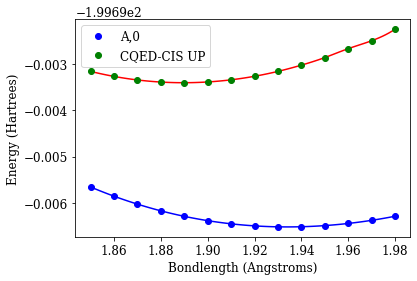

In [10]:
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import rcParams

cqed_cis_spline = InterpolatedUnivariateSpline(r_array, np.real(cqed_cis_energy_array[2,:]), k=3)
cis_spline = InterpolatedUnivariateSpline(r_array, np.real(cis_energy_array[0,:]), k=3)


r_fine = np.linspace(1.85, 1.98, 100)
cqed_cis_e_fine = cqed_cis_spline(r_fine)
cis_e_fine = cis_spline(r_fine)


print("cqed_cis",r_fine[np.argmin(cqed_cis_e_fine)])
print("cis",r_fine[np.argmin(cqed_rhf_e_fine)])

# get curvatures of each surface
cqed_cis_f = cqed_cis_spline.derivative()
cqed_cis_c = cqed_cis_f.derivative()

cis_f = cis_spline.derivative()
cis_c = cis_f.derivative()


# get locations of equilibrium geometry
r_eq_cqed_cis = r_fine[np.argmin(cqed_cis_e_fine)]
r_eq_cis = r_fine[np.argmin(cis_e_fine)]

# print location of equilibrium bondlength
print("cqed_cis",r_eq_cqed_cis)
print("rhf",r_eq_cis)

# print curvature evaluated at equilibrium geometries
k_cqed_cis = cqed_cis_c(r_eq_cqed_cis)
k_cis = cis_c(r_eq_cis)

# print the force constant of each surface in atomic units
print("cqed_cis",k_cqed_cis)
print("cis",k_cis)


rcParams['font.family'] = 'serif'
rcParams['font.size'] = 12
plt.plot(r_fine, cqed_cis_e_fine, 'red')
plt.plot(r_fine, cis_e_fine, 'blue')
plt.plot(r_array, cis_energy_array[0,:], 'bo', label='A,0')
plt.plot(r_array, np.real(cqed_cis_energy_array[2,:]), 'go', label="CQED-CIS UP")
plt.xlabel("Bondlength (Angstroms)")
plt.ylabel("Energy (Hartrees)")
plt.legend()
plt.show()


# Deviations of CQED-CIS from models (Fig 6)
We will compare the lower and upper-polariton energies for MgH+ at a geometry of 2.2 Angstroms when coupled to a 4.75 eV photon with various coupling strength, looking for the onset of deviations between the eigenvalues from CQED-CIS and those coming from simpler model Hamiltonians parameterized by CIS values for lone MgH+.

In [17]:
# template for z-matrix
mol_str = """
Mg
H 1 2.2
symmetry c1
1 1
"""
n_lam = 20
# electric field strength 
lam_z = np.linspace(0, 0.025, n_lam) 

# set psi4 options
psi4.set_options(options_dict)

# arrays to hold psi4 cis quantities to fit the model PF Hamiltonian with
# array for transition dipole moments
tdm_array = np.zeros((3, n_lam))

# array for total diplole of ground and excited state 
dipole_array = np.zeros((3,2,n_lam))

# array for ordinary cis
cis_energy_array = np.zeros((5,n_lam))

# array to hold the cs-cqed-cis energies
# array for cqed cis
cqed_cis_energy_array = np.zeros((5, n_lam),dtype=complex)

# array for model Pauli-Fierz energies
pf = np.zeros((3,n_lam),dtype=complex)

# array for Jaynes-Cummings energies
jc = np.zeros((2,n_lam),dtype=complex)


# photon energy
om_r = 4.75 / 27.211



print(" value of gamma to cross over from weak to strong coupling:", 4 * g_max)
om = om_r 

# lambda vector
#lam = np.array([0,0,lam_z])

# loop over the different bond-lengths, create different instances
# of MgH+ molecule and compute and store various quantities
ctr = 0
for l in lam_z:
    lam = np.array([0, 0, l])
    mol = psi4.geometry(mol_str)
    e, wfn = psi4.energy("scf/cc-pVDZ", return_wfn=True, molecule=mol)
    
    # confirm our cis agrees with psi4
    res = tdscf_excitations(wfn, states=3, triplets = "NONE", tda=True)
    
    # parse res for excitation energies
    psi4_excitation_e = [r["EXCITATION ENERGY"] for r in res]
    
    cis_e, cis_c, cis_mu, tdm = cis(mol_str, options_dict)
    
    cis_energy_array[0,ctr] = e
    cis_energy_array[0,ctr] = e+psi4_excitation_e[0]
    
    pf[0,ctr], pf[1,ctr], pf[2,ctr], vecs = pauli_fierz(e, e+cis_e[0], om, lam, cis_mu[:,0], cis_mu[:,1], tdm)
    jc[0,ctr], jc[1,ctr] = jaynes_cummings(e, e+cis_e[0], om, lam,  tdm)
    
    assert np.isclose(cis_e[0], psi4_excitation_e[0])
    assert np.isclose(cis_e[1], psi4_excitation_e[1])
    
    cqed_dict = cs_cqed_cis(lam, om, mol_str, options_dict)
    
    # get cqed-rhf energy
    cqed_scf_e = cqed_dict['CQED-RHF ENERGY']
    # get cqed-cis excitation energies
    cqed_cis_e = cqed_dict['CQED-CIS ENERGY']
    # store to arrays
    cqed_cis_energy_array[0:5,ctr] = cqed_scf_e+cqed_cis_e[0:5]
    ctr+=1
    

 

 value of gamma to cross over from weak to strong coupling: 0.033236254686047906
printing eps
[-4.93826135e+01 -4.10514607e+00 -2.62427840e+00 -2.62427840e+00
 -2.62120726e+00 -5.59918990e-01 -2.55356636e-01 -1.51177160e-01
 -1.51177160e-01 -6.62272370e-02 -1.10729221e-02  5.64148516e-02
  5.82266274e-02  5.82266274e-02  2.03748034e-01  2.03748034e-01
  2.05109157e-01  2.05109157e-01  3.02034569e-01  6.14807659e-01
  1.38241512e+00  1.38241512e+00  1.62129237e+00]

Number of occupied orbitals: 6
C
23
Cocc
23

Start SCF iterations:

Canonical RHF One-electron energy = -281.6658775695342456
CQED-RHF One-electron energy      = -281.6658775695342456
Nuclear repulsion energy          = 2.8864211491090908
Dipole energy                     = 0.0000000000000000
SCF Iteration   1: Energy = -199.8639591041890924   dE = -1.99864E+02   dRMS = 4.60183E-08
SCF Iteration   2: Energy = -199.8639591041913661   dE = -2.27374E-12   dRMS = 1.41134E-08
Total time for SCF iterations: 0.004 seconds 

QED-RHF

printing eps
[-4.93826135e+01 -4.10514607e+00 -2.62427840e+00 -2.62427840e+00
 -2.62120726e+00 -5.59918990e-01 -2.55356636e-01 -1.51177160e-01
 -1.51177160e-01 -6.62272370e-02 -1.10729221e-02  5.64148516e-02
  5.82266274e-02  5.82266274e-02  2.03748034e-01  2.03748034e-01
  2.05109157e-01  2.05109157e-01  3.02034569e-01  6.14807659e-01
  1.38241512e+00  1.38241512e+00  1.62129237e+00]

Number of occupied orbitals: 6
C
23
Cocc
23

Start SCF iterations:

Canonical RHF One-electron energy = -281.6658775695342456
CQED-RHF One-electron energy      = -281.6659833857856370
Nuclear repulsion energy          = 2.8864211491090908
Dipole energy                     = 0.0006712428509754
SCF Iteration   1: Energy = -199.8635132498923497   dE = -1.99864E+02   dRMS = 1.79433E-05
SCF Iteration   2: Energy = -199.8635138391013584   dE = -5.89209E-07   dRMS = 6.78828E-06
SCF Iteration   3: Energy = -199.8635139095388240   dE = -7.04375E-08   dRMS = 2.57134E-06
Total time for SCF iterations: 0.006 seconds

C
23
Cocc
23

Start SCF iterations:

Canonical RHF One-electron energy = -281.6658775695342456
CQED-RHF One-electron energy      = -281.6662495797933730
Nuclear repulsion energy          = 2.8864211491090908
Dipole energy                     = 0.0023598381479605
SCF Iteration   1: Energy = -199.8623916476776117   dE = -1.99862E+02   dRMS = 6.30501E-05
SCF Iteration   2: Energy = -199.8623988831626548   dE = -7.23549E-06   dRMS = 2.36494E-05
SCF Iteration   3: Energy = -199.8623997351702997   dE = -8.52008E-07   dRMS = 8.92393E-06
SCF Iteration   4: Energy = -199.8623998560071868   dE = -1.20837E-07   dRMS = 3.39296E-06
SCF Iteration   5: Energy = -199.8623998735262717   dE = -1.75191E-08   dRMS = 1.29549E-06
Total time for SCF iterations: 0.011 seconds 

QED-RHF   energy: -199.86239987 hartree
Psi4  SCF energy: -199.86395910 hartree
printing eps
[-4.93826135e+01 -4.10514607e+00 -2.62427840e+00 -2.62427840e+00
 -2.62120726e+00 -5.59918990e-01 -2.55356636e-01 -1.51177160e-01
 -1.51177160

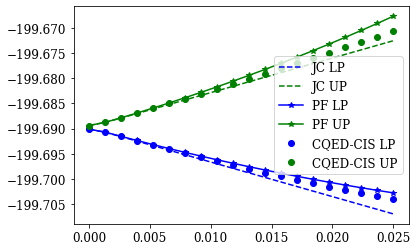

In [18]:
plt.plot(lam_z, np.real(jc[0,:]), 'b--', label="JC LP")
plt.plot(lam_z, np.real(jc[1,:]), 'g--', label="JC UP")
plt.plot(lam_z, np.real(pf[1,:]), 'b-*', label="PF LP")
plt.plot(lam_z, np.real(pf[2,:]), 'g-*', label="PF UP")
plt.plot(lam_z, np.real(cqed_cis_energy_array[1,:]), 'bo', label="CQED-CIS LP")
plt.plot(lam_z, np.real(cqed_cis_energy_array[2,:]), 'go', label="CQED-CIS UP")
plt.legend()
plt.show()